<a href="https://colab.research.google.com/github/tibaris/EntropicSparsificationNN/blob/main/swiss_roll_2lyrs2turnsbigger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from skimage import io, exposure

import numpy as np
import scipy
import scipy.ndimage
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from scipy.ndimage import gaussian_filter

import time
from skimage.color import rgb2gray
from skimage.transform import rescale

In [2]:

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn import svm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sched

In [4]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
import csv
import pandas as pd
import time
import gc
import sys

In [6]:
train_data = pd.read_csv("/content/swissroll-10000-turn2.csv", header=None)
train_data = train_data.to_numpy()

In [7]:
train_data.shape

(2, 20000)

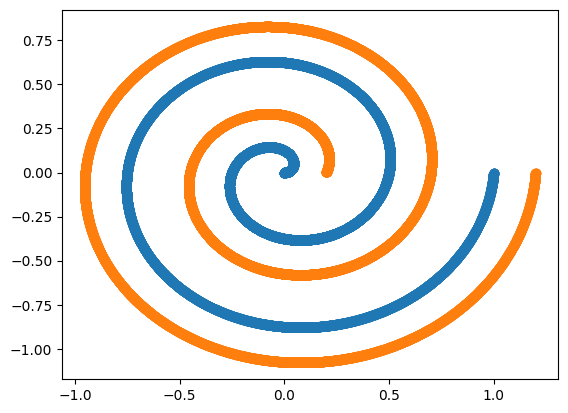

In [8]:
xA = train_data[0,:10000]
yA = train_data[1,:10000]
xB = train_data[0,10000:]
yB = train_data[1,10000:]
plt.scatter(xA,yA)
plt.scatter(xB,yB)

In [9]:
train_data = np.transpose(train_data)
train_data = torch.from_numpy(train_data)
print(train_data.shape)

torch.Size([20000, 2])


In [10]:
train_num = train_data.shape[0]
torch.manual_seed(0)
permutation = torch.randperm(train_num)

In [11]:
train_x = train_data[permutation[:15000],:]
train_y = (permutation[:15000]<train_num/2)*1
train_x = train_x.reshape([train_x.shape[0],train_x.shape[1],1,1])
print(train_x.shape)
print(train_y.shape)

torch.Size([15000, 2, 1, 1])
torch.Size([15000])


In [12]:
test_x = train_data[permutation[15000:],:]
test_y = (permutation[15000:]<train_num/2)*1
test_x = test_x.reshape([test_x.shape[0],test_x.shape[1],1,1])
print(test_x.shape)
print(test_y.shape)

torch.Size([5000, 2, 1, 1])
torch.Size([5000])


In [13]:
train_y

tensor([0, 0, 1,  ..., 1, 1, 0])

In [14]:
class SimplePerceptron(nn.Module):

    def __init__(self):
        super(SimplePerceptron, self).__init__()
        self.conv1 = nn.Conv2d(2,400,kernel_size = (1,1))
        self.conv2 = nn.Conv2d(400,400,kernel_size = (1,1))
        self.conv3 = nn.Conv2d(400,400,kernel_size = (1,1))
        self.conv4 = nn.Conv2d(400,1,kernel_size = (1,1))

        self.bn1 = nn.BatchNorm2d(400, affine=False)
        self.bn2 = nn.BatchNorm2d(400, affine=False)
        self.bn3 = nn.BatchNorm2d(400, affine=False)


    def forward(self, x):

        #1st  layer
        #x = self.bn1(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.conv4(x)
        #x = F.softmax(x)
        x = F.sigmoid(x)
        return x

In [15]:
model = SimplePerceptron().double()
print(count_parameters(model))

322401


In [16]:
n_epochs = 20 # or whatever
batch_size = 50 # or whatever
train_num = 10000

optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = sched.StepLR(optimizer, step_size=4, gamma=0.5)

input = train_x[:10000].double()
target = train_y[:10000].double()

input_v = train_x[10000:].double()
target_v = train_y[10000:].double()

criterion_val = nn.BCELoss()
#criterion_val = loss = nn.CrossEntropyLoss()

for epoch in range(n_epochs):

    # X is a torch Variable
    permutation = torch.randperm(train_num)
    if(epoch % 2 == 1):
        print("Epoch:")
        print(epoch)
        print("Train loss:")
        print(t_loss/train_num*batch_size)
        print("val:")
        val_loss=0
        model.eval()
        v1 = model(input_v)
        #for i in range(200):
            #v1 = model(input_v[(i*50):((i+1)*50)])
            #v2  = target_v[(i*50):((i+1)*50)]
            #v1 = torch.argmax(v1, dim=1)
            #print(v1.shape)
        val_loss = criterion_val(v1[:,0,0,0],target_v)
        #gc.collect()
        #val_loss = val_loss + criterion_val(v1[:,:,0,0],v2)
        #print(criterion_val(model.forward(val_x2), val_y2))
        print("Validation loss:")
        print(val_loss)
        print("--------")
        model.train()
    t_loss = 0
    gc.collect()

    for i in range(0,train_num, batch_size):
        optimizer.zero_grad()
        indices = permutation[i:(i+batch_size)]
        batch_x = input[indices]
        batch_y = target[indices]
        #batch_w = input_w[indices]
        #criterion3 = nn.BCELoss(weight=batch_w)
        #print(batch_x.shape)
        outputs = model.forward(batch_x)
        #print(outputs[:,:,0,0].shape)
        #print(torch.max(outputs[:,:,0,0]))
        #print(torch.max(batch_y))
        #print(torch.min(batch_y))
        #print(batch_y.shape)
        #loss = criterion3(outputs,batch_y)
        loss = criterion_val(outputs[:,0,0,0],batch_y)
        #print(loss)

        if(epoch % 2 == 0):
            t_loss += loss

        loss.backward()
        optimizer.step()
        gc.collect()

    scheduler.step()
    gc.collect()

Epoch:
1
Train loss:
tensor(0.4810, dtype=torch.float64, grad_fn=<MulBackward0>)
val:
Validation loss:
tensor(0.2706, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)
--------
Epoch:
3
Train loss:
tensor(0.3286, dtype=torch.float64, grad_fn=<MulBackward0>)
val:
Validation loss:
tensor(0.1139, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)
--------
Epoch:
5
Train loss:
tensor(0.2736, dtype=torch.float64, grad_fn=<MulBackward0>)
val:
Validation loss:
tensor(0.0552, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)
--------
Epoch:
7
Train loss:
tensor(0.2806, dtype=torch.float64, grad_fn=<MulBackward0>)
val:
Validation loss:
tensor(0.0571, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)
--------
Epoch:
9
Train loss:
tensor(0.2762, dtype=torch.float64, grad_fn=<MulBackward0>)
val:
Validation loss:
tensor(0.0584, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)
--------
Epoch:
11
Train loss:
tensor(0.2792, dtype=torch.float64, grad_fn

In [17]:
def accuracy(y1,y2):
    train_acc = torch.sum(y1 == y2)
    print(train_acc)
    final_train_acc = train_acc/y2.shape[0]
    return final_train_acc

In [18]:
model.eval()

SimplePerceptron(
  (conv1): Conv2d(2, 400, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(400, 400, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(400, 400, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(400, 1, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (bn2): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (bn3): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
)

In [19]:
#train
v = model(input)
v[v>=0.5] = 1
v[v<0.5] = 0
#val
v1 = model(input_v)
v1[v1>=0.5] = 1
v1[v1<0.5] = 0
#test
v2 = model(test_x)
v2[v2>=0.5] = 1
v2[v2<0.5] = 0

In [20]:
print(accuracy(v[:,0,0,0],target))
print(accuracy(v1[:,0,0,0],target_v))
print(accuracy(v2[:,0,0,0],test_y))

tensor(10000)
tensor(1.)
tensor(5000)
tensor(1.)
tensor(5000)
tensor(1.)


In [21]:
test_x.shape

torch.Size([5000, 2, 1, 1])

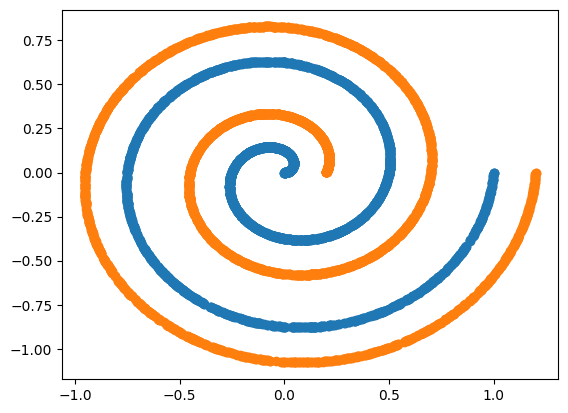

In [22]:

xA = test_x[v2[:,0,0,0]==1,0,0,0]
yA = test_x[v2[:,0,0,0]==1,1,0,0]
xB = test_x[v2[:,0,0,0]==0,0,0,0]
yB = test_x[v2[:,0,0,0]==0,1,0,0]
plt.scatter(xA,yA)
plt.scatter(xB,yB)

Visualization

In [23]:
print(torch.min(test_x[:,0,0,0]))
print(torch.max(test_x[:,0,0,0]))
print(torch.min(test_x[:,1,0,0]))
print(torch.max(test_x[:,1,0,0]))

tensor(-0.9533, dtype=torch.float64)
tensor(1.1998, dtype=torch.float64)
tensor(-1.0779, dtype=torch.float64)
tensor(0.8288, dtype=torch.float64)


In [24]:
Lx = -1.5
Rx = 1.5
Ly = -1.5
Ry = 1.5

In [25]:
#grid
x1 = np.array([0])
x2 = np.array([0])
for i in range(100):
  for j in range(100):
    x1 = np.concatenate([x1,[-1.5+3/100*i]])
    x2 = np.concatenate([x2,[-1.5+3/100*j]])

In [26]:
x1.shape
torch.from_numpy(x1).shape


torch.Size([10001])

In [27]:
grid = torch.zeros([pow(10,4)+1,2,1,1])
print(grid.shape)
grid[:,0,0,0] = torch.from_numpy(x1)
grid[:,1,0,0] = torch.from_numpy(x2)

torch.Size([10001, 2, 1, 1])


In [28]:
v = model(grid.double())
v[v>=0.5] = 1
v[v<0.5] = 0

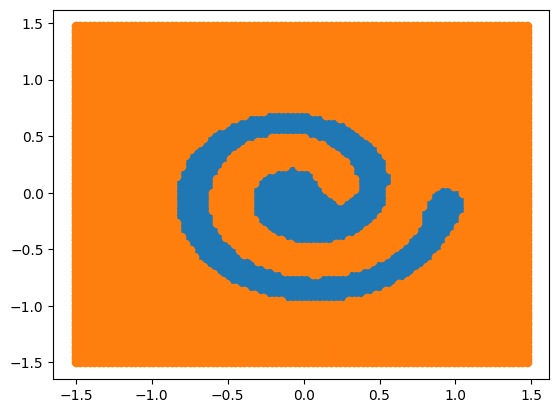

In [29]:
xA = grid[v[:,0,0,0]==1,0,0,0]
yA = grid[v[:,0,0,0]==1,1,0,0]
xB = grid[v[:,0,0,0]==0,0,0,0]
yB = grid[v[:,0,0,0]==0,1,0,0]
plt.scatter(xA,yA)
plt.scatter(xB,yB)

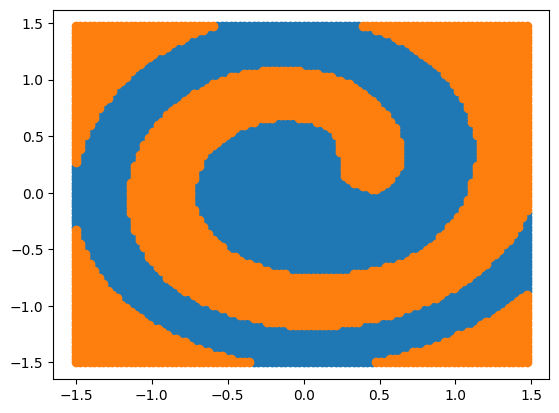

In [ ]:
xA = grid[v[:,0,0,0]==1,0,0,0]
yA = grid[v[:,0,0,0]==1,1,0,0]
xB = grid[v[:,0,0,0]==0,0,0,0]
yB = grid[v[:,0,0,0]==0,1,0,0]
plt.scatter(xA,yA)
plt.scatter(xB,yB)

In [30]:
#torch.save(model.state_dict(), "/content/FCC-swiss-roll-2turn-10kbig-corrected.pth")

In [ ]:
for epoch in range(n_epochs):

    # X is a torch Variable
    permutation = torch.randperm(train_num)
    if(epoch % 2 == 1):
        print("Epoch:")
        print(epoch)
        print("Train loss:")
        print(t_loss/train_num*batch_size)
        print("val:")
        val_loss=0
        model.eval()
        v1 = model(input_v)
        #for i in range(200):
            #v1 = model(input_v[(i*50):((i+1)*50)])
            #v2  = target_v[(i*50):((i+1)*50)]
            #v1 = torch.argmax(v1, dim=1)
            #print(v1.shape)
        val_loss = criterion_val(v1[:,0,0,0],target_v)
        #gc.collect()
        #val_loss = val_loss + criterion_val(v1[:,:,0,0],v2)
        #print(criterion_val(model.forward(val_x2), val_y2))
        print("Validation loss:")
        print(val_loss)
        print("--------")
        model.train()
    t_loss = 0
    gc.collect()

    for i in range(0,train_num, batch_size):
        optimizer.zero_grad()
        indices = permutation[i:(i+batch_size)]
        batch_x = input[indices]
        batch_y = target[indices]
        #batch_w = input_w[indices]
        #criterion3 = nn.BCELoss(weight=batch_w)
        #print(batch_x.shape)
        outputs = model.forward(batch_x)
        #print(outputs[:,:,0,0].shape)
        #print(torch.max(outputs[:,:,0,0]))
        #print(torch.max(batch_y))
        #print(torch.min(batch_y))
        #print(batch_y.shape)
        #loss = criterion3(outputs,batch_y)
        loss = criterion_val(outputs[:,0,0,0],batch_y)
        #print(loss)

        if(epoch % 2 == 0):
            t_loss += loss

        loss.backward()
        optimizer.step()
        gc.collect()

    scheduler.step()
    gc.collect()

Epoch:
1
Train loss:
tensor(0.4454, dtype=torch.float64, grad_fn=<MulBackward0>)
val:
Validation loss:
tensor(0.3354, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)
--------


In [ ]:
#train
v = model(input)
v[v>=0.5] = 1
v[v<0.5] = 0
#val
v1 = model(input_v)
v1[v1>=0.5] = 1
v1[v1<0.5] = 0
#test
v2 = model(test_x)
v2[v2>=0.5] = 1
v2[v2<0.5] = 0

In [ ]:
print(accuracy(v[:,0,0,0],target))
print(accuracy(v1[:,0,0,0],target_v))
print(accuracy(v2[:,0,0,0],test_y))

In [ ]:
#grid
x1 = np.array([0])
x2 = np.array([0])
for i in range(100):
  for j in range(100):
    x1 = np.concatenate([x1,[-1.5+3/100*i]])
    x2 = np.concatenate([x2,[-1.5+3/100*j]])

In [ ]:
v = model(grid.double())
v[v>=0.5] = 1
v[v<0.5] = 0

In [ ]:
xA = grid[v[:,0,0,0]==1,0,0,0]
yA = grid[v[:,0,0,0]==1,1,0,0]
xB = grid[v[:,0,0,0]==0,0,0,0]
yB = grid[v[:,0,0,0]==0,1,0,0]
plt.scatter(xA,yA)
plt.scatter(xB,yB)